# Practica 2

_Autores_

-   Palmer Pérez, Rubén

## Descipción de la practica

Dado el dataset de [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), se nos asigna las siguientes questiones a resolver mediante el uso de [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network):

1. Clasificación perros vs gatos; Mediante el uso de una erd creada a mano y una ya entrenada.
2. Clasificación de la raza
3. Detección de la posición de la cabeza
4. Segmentación del animal

En este documento se examina el proceso de aprendizaje, procesamiento de datos y pruebas que han llevado a la solución de los dos primeros puntos:

1. Clasificación perros vs gatos; Mediante el uso de una erd creada a mano y una ya entrenada.
2. Clasificación de la raza

## Paquetes


In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import warnings

warnings.filterwarnings("ignore")

from os import path, listdir
from torchvision import transforms
from torchview import draw_graph
import torch.optim as optim

from torch.utils.data import DataLoader

import pandas as pd
from skimage import filters, img_as_ubyte, color, img_as_float
from skimage.transform import rotate
from skimage.io import imread, imsave
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from functools import reduce
from operator import sub
from CatDogDataset import CatDogDataset
from network import CatDogNet
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Preparación del entorno


In [2]:
CONFIG = {
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "IMAGE_SIZE": (128, 128),
    "DATA_PATH": path.join(path.abspath(path.pardir), "data", "images"),
    "SEED": 27,
    "MODEL": {"EPOCH": 15, "LEARNING_RATE": 0.00001},
}

random.seed(CONFIG.get("SEED"))

Adicionalmente, eliminaremos posibles artefactos de previas ejecuciones


In [3]:
files_to_remove = (
    os.path.join(folder, file)
    for folder, _, files in os.walk(path.join(CONFIG.get("DATA_PATH")))
    for file in files
    if "generated" in file
)

any(map(os.remove, files_to_remove))

False

## Datos

El conjunto de datos establece lo siguiente en los documentos adjuntos de etiquetado

_Todas las imágenes con la 1ª letra en mayúscula son imágenes de gatos, mientras que las imágenes con la primera letra en minúscula son imágenes de perros._

Gracias a que el nombre del archivo tambien indica la raza del animal, utilizaremos el nombre de cada imagen para generar un `dataframe` que contenga el `path` de cada imagen y las etiquetas necesarias. Adicionalmente comentar que, aunque se podría directamente codificar las etiquetas para su futuro uso, se mantendrá el uso de etiquetas con una mayor carga semántica; evitando los [números mágicos](<https://en.wikipedia.org/wiki/Magic_number_(programming)>) fuera del estudio de los datos


In [4]:
image_files = [
    path.join(CONFIG.get("DATA_PATH"), file)
    for file in listdir(CONFIG.get("DATA_PATH"))
    if file.endswith(".jpg")
]

labels = pd.DataFrame(
    {
        "image_name": image_files,
        "species": [
            "cat" if path.basename(file)[0].isupper() else "dog" for file in image_files
        ],
        "breed": [
            "_".join(path.basename(file).split("_")[:-1]).lower()
            for file in image_files
        ],
    }
)
labels

,image_name,species,breed
0,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
1,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
2,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
3,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
4,c:\Users\Eden\Documents\projects\AA_Practica2\...,cat,abyssinian
...,...,...,...
7385,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier
7386,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier
7387,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier
7388,c:\Users\Eden\Documents\projects\AA_Practica2\...,dog,yorkshire_terrier


Comentar que, explorando los diferentes tipos de imagenes manualmente, se han encontrado diferentes extensiones. Con el objetivo de simplificar el proceso de procesamiento de imagenes, se ha decidido obtener exclusivamente las imágenes `.jpg`


### Analisis

Antes de cargar las imágenes, se examinarán las etiquetas y las imágenes para ver si existen patrones, desbalances en las clasificaciones, etc. Principalmente, nos interesa ver la distribución general de las etiquetas para comprobar si están equilibradas, ya que un desequilibrio podría afectar al rendimiento de los modelos.


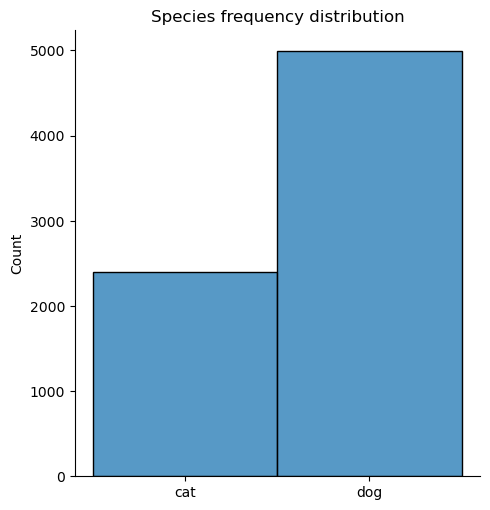

In [5]:
sns.displot(
    labels["species"].values,
)
plt.title("Species frequency distribution")
plt.show()

Se puede observar un claro desbalance de las especies, viendo que hay casi el _doble_ de perros que gatos. En estos casos, se nos presentan tres posibilidades:

-   Permanecer en este estado: El modelo podría predecir erroneamente unicamente por la cantidad de datos. Por ejemplo, en un caso extremo, si tuviéramos 1 gato y 99 perros, el modelo etiquetaría todas las imágenes como perros, ya que tiene un 99% de probabilidades de acertar.
-   **Downsample**: Eliminar aleatoriamente observaciones de los perros hasta llegar al mismo numero de gatos; posiblemente reduciendo la precisión de acierto ante las predicciones del os perros
-   **Upsample**: Usar [aumento de datos](https://en.wikipedia.org/wiki/Data_augmentation) para generar nuevos gatos hasta llegar a la cantida de perros; posiblemente creando `overfitting`

En este especifico caso, y con objetivo academico, se ha decidido generar imagenes de gatos

Tambien podemos observar la distribución de las razas:


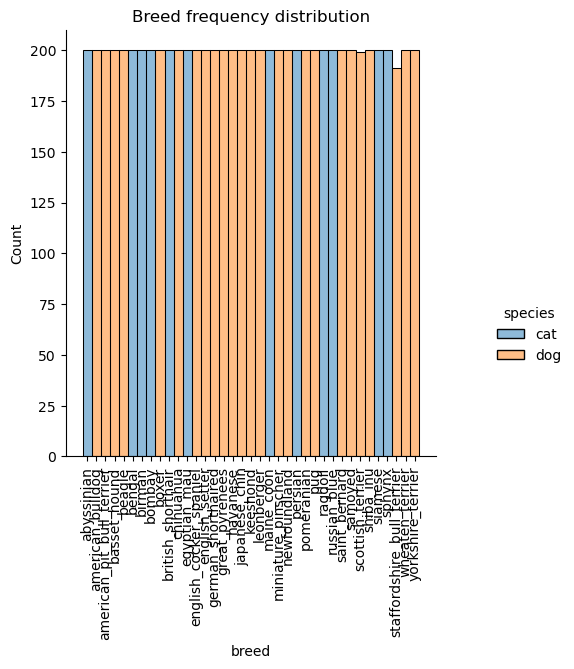

In [6]:
sns.displot(data=labels, x="breed", hue="species")
plt.title("Breed frequency distribution")
plt.xticks(rotation=90)
plt.show()

Su distribución es relativamente estable, excepto por `stanffordshire_bull_terrier` y `scotish_terrier` que tienen ligeramente menos datos, por lo que no será necesario modificar los datos con respecto a la especie


## Gatos VS Perros: Clasificación

### Aumento de datos

Como ya se ha mencionado previamente, la falta de observaciones de gatos crea un desbalance de fequencia. Para reducir dicho impacto, se generarán nuevos gatos aplicando un conjunto aleatorio de transformaciones. Al final del proceso pues, deberíamos obtener un conjunto de imagenes de gatos adicionales que, idealmente, sean suficientemente fierentes como para que el modelo no sufra de `overfitting` o al menos se pueda reducir su efecto.

In [7]:
manipulations = [
    lambda img: rotate(img, random.randint(0, 360), mode="wrap"),
    lambda img: random_noise(img, seed=CONFIG.get("SEED"), mode="s&p", amount=0.1),
    lambda img: random_noise(img, seed=CONFIG.get("SEED"), mode="gaussian", var=0.01),
    lambda img: img[::-1, ::-1],
    lambda img: filters.gaussian(img, sigma=1),
]

PROPORTIONAL_MANIPULATION_AMOUNT = 2

cat_data = labels[labels["species"] == "cat"]["image_name"].to_list()

amount_of_cats = abs(sub(*labels["species"].value_counts().values))

records = []

for i in range(amount_of_cats):
    random_manipulations = random.sample(
        manipulations,
        random.randint(1, len(manipulations) // PROPORTIONAL_MANIPULATION_AMOUNT),
    )

    choice = random.choice(cat_data)
    img = reduce(
        lambda img, manipulation: manipulation(img),
        random_manipulations,
        imread(choice),
    )

    try:
        imsave(
            path.join(path.join(CONFIG.get("DATA_PATH")), f"generated{i}.jpg"),
            img_as_ubyte(img),
        )
    except:
        print("Had some error with image", choice, "skiping...")
        continue

    records.append(
        {
            "image_name": path.join(
                path.join(CONFIG.get("DATA_PATH")), f"generated{i}.jpg"
            ),
            "species": "cat",
            "breed": "_".join(path.basename(choice).split("_")[:-1]).lower(),
        }
    )

labels_cat_dogs = pd.concat([labels, pd.DataFrame(records)])

Had some error with image c:\Users\Eden\Documents\projects\AA_Practica2\data\images\Abyssinian_5.jpg skiping...
Had some error with image c:\Users\Eden\Documents\projects\AA_Practica2\data\images\Egyptian_Mau_186.jpg skiping...
Had some error with image c:\Users\Eden\Documents\projects\AA_Practica2\data\images\Abyssinian_5.jpg skiping...


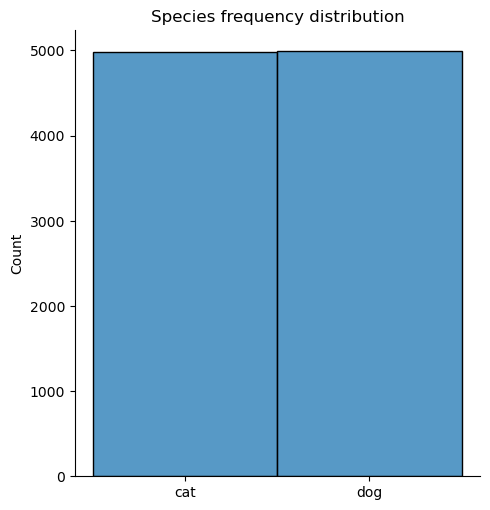

In [8]:
sns.displot(
    labels_cat_dogs["species"].values,
)
plt.title("Species frequency distribution")
plt.show()

Ahora pues, tenemos un conjunto de datos balanceados con respecto a la especie de los animales.

### `Finetunning` de la media y la desviación estandar

Al aplicar las transformaciones, se suele normalizar los datos de entrada para reducir la posible contribución de errores por valores extremos. Para ello, sse suelen usar los siguientes valores:

-   media: [0.485, 0.456, 0.406]
-   std: [0.229, 0.224, 0.225]

Que son los los obtenidos por [ImageNet](https://image-net.org/). Sin embargo, y por razones académicas, se calcularán dichos valores especificamente para nuestro conjunto de datos.


In [9]:
def calculate_mean_std(paths: list[str]) -> tuple[int, int]:
    mean = np.zeros(3)
    std = np.zeros(3)

    for path in paths:
        try:
            img = imread(path)
            img = img_as_float(img)
            if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
                img = color.gray2rgb(img)
            img = img.transpose((2, 0, 1))
            img = img.reshape(3, -1)
            mean += img.mean(axis=1)
            std += img.std(axis=1)
        except:
            print("failure on image", path, " skiping...")
            continue

    mean /= len(paths)
    std /= len(paths)

    return mean.tolist(), std.tolist()


norm_data = calculate_mean_std(labels_cat_dogs["image_name"])
norm_data

Los resultados, siendo extremadamente parecidos a los de ImageNet, nos reafirman que estamos cerca del dominio de resultados para imagenes genericas y que estos valores no son más que una especialización para este entrenamiento


In [10]:
transform = transforms.Compose(
    [
        transforms.Resize(CONFIG.get("IMAGE_SIZE")),
        transforms.ToTensor(),
        transforms.Normalize(*norm_data),
    ]
)

### Codificación de las etiquetas

Como ya se mencionó previamante, la etiquetas que actualmente poseemos están cargadas semánticamente. Sin embargo, para ofrecerlas como `target` para el modelo, será necesaria codificarlas numericamente:


In [16]:
encoder = LabelEncoder()
labels_cat_dogs["species"] = encoder.fit_transform(labels_cat_dogs["species"])
print(set(labels_cat_dogs["species"]))

{0, 1}


### Entrenamiento, validación y prueba

En este caso usaremos la división 70/15/15 encontrados [aquí](https://www.v7labs.com/blog/train-validation-test-set).


In [ ]:
rest_data, train_data, rest_pred, train_pred = train_test_split(
    labels_cat_dogs["image_name"].values,
    labels_cat_dogs["species"].values,
    test_size=0.7,
    random_state=CONFIG.get("SEED"),
)

val_data, test_data, val_pred, test_pred = train_test_split(
    rest_data, rest_pred, test_size=0.5, random_state=CONFIG.get("SEED")
)

Adicionalmente, se ha creado una implementación personalizada basada en el modulo [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) de Pytorch, permitiendonos un uso sencillo e intuitivo de los `DataLoader`, encargados de ofrecer los datos al modelo aplicando las transformaciones especificadas previamente


In [12]:
train_dl = DataLoader(CatDogDataset(train_data, train_pred, transform), batch_size=100)
val_dl = DataLoader(CatDogDataset(val_data, val_pred, transform), batch_size=100)
test_dl = DataLoader(CatDogDataset(test_data, test_pred, transform), batch_size=100)

### Especificación del modelo

La CNN diseñada tiene como objetivo la clasificación binaria entre gatos y perros. Para ello se ha implementado la siguiente arquitectura:

-   **Bloque convolucional**: un conjunto de bloques que aplican `Convolution2D`, `batch normalization`, `ReLU` y `MaxPool2D`. tiene como objetivo encargarse de aplicr dichas convoluciones reduciendo al maximo el ruido y los parametros
-   **Dropout**: Para reducir la posibilidad de `overfitting` con el tradeback de posiblemente no llegar a su maximo nivel de predicción
-   **1Dimensional**: Un conjunto de capas que, un vez transformado la matriz en un vector, aplican capas lineales

A continuación se podrá ver la representación grafica de la arquitectura usando [torchview](https://github.com/mert-kurttutan/torchview)



(dot.exe:54112): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


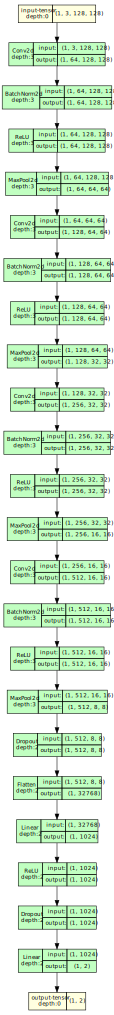

In [14]:
model = CatDogNet()
draw_graph(model, input_size=(1, 3, 128, 128), device="meta").visual_graph

### Entrenamiento

Finalmente, entrenaremos el modelo un total de 15 epochs


In [17]:
def train(model, optimizer, criterion, epochs, train_loader, validation_loader):
    train_acc = []
    valid_acc = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(CONFIG.get("DEVICE"))
            label = label.to(CONFIG.get("DEVICE"))

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_acc.append(epoch_accuracy)
        print(
            "Epoch : {}, train accuracy : {}, train loss : {}".format(
                epoch + 1, epoch_accuracy, epoch_loss
            )
        )

        # Validation
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in validation_loader:
                data = data.to(CONFIG.get("DEVICE"))
                label = label.to(CONFIG.get("DEVICE"))

                val_output = model(data)
                val_loss = criterion(val_output, label)
                # No optimizer as we don't want to change the weights

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(validation_loader)
                epoch_val_loss += val_loss / len(validation_loader)

            valid_acc.append(epoch_val_accuracy)
            print(
                "Epoch : {}, val_accuracy : {}, val_loss : {}".format(
                    epoch + 1, epoch_val_accuracy, epoch_val_loss
                )
            )

    return train_acc, valid_acc


model = CatDogNet().to(CONFIG.get("DEVICE"))
model.train()
optimizer = optim.Adam(
    params=model.parameters(), lr=CONFIG.get("MODEL").get("LEARNING_RATE")
)
criterion = torch.nn.CrossEntropyLoss()
epochs = CONFIG.get("MODEL").get("EPOCH")

train_acc, valid_acc = train(model, optimizer, criterion, epochs, train_dl, val_dl)

Epoch : 1, train accuracy : 0.6414557099342346, train loss : 0.6387099623680115
Epoch : 1, val_accuracy : 0.663194477558136, val_loss : 0.605043351650238
Epoch : 2, train accuracy : 0.7061701416969299, train loss : 0.5737598538398743
Epoch : 2, val_accuracy : 0.6873888373374939, val_loss : 0.5852506160736084
Epoch : 3, train accuracy : 0.7276802659034729, train loss : 0.5369309186935425
Epoch : 3, val_accuracy : 0.7187777161598206, val_loss : 0.5506958961486816
Epoch : 4, train accuracy : 0.7545102834701538, train loss : 0.5005353093147278
Epoch : 4, val_accuracy : 0.7345278263092041, val_loss : 0.5345092415809631
Epoch : 5, train accuracy : 0.7764216661453247, train loss : 0.46725648641586304
Epoch : 5, val_accuracy : 0.7527222633361816, val_loss : 0.507503867149353
Epoch : 6, train accuracy : 0.7897346019744873, train loss : 0.4415668845176697
Epoch : 6, val_accuracy : 0.7521389126777649, val_loss : 0.5113049745559692
Epoch : 7, train accuracy : 0.8091496229171753, train loss : 0.415

Podemos guardar el actual estado del modelo con pytorch de la siguiente manera:


In [ ]:
torch.save(
    model.state_dict(), path.join(path.dirname(CONFIG.get("DATA_PATH")), "model")
)

Adicionalmente, y con el objetivo de apreciar si el modelo ha sufrido de overfitting, se visualizará las `time series` del `accuracy` del entrenamiento y la validación


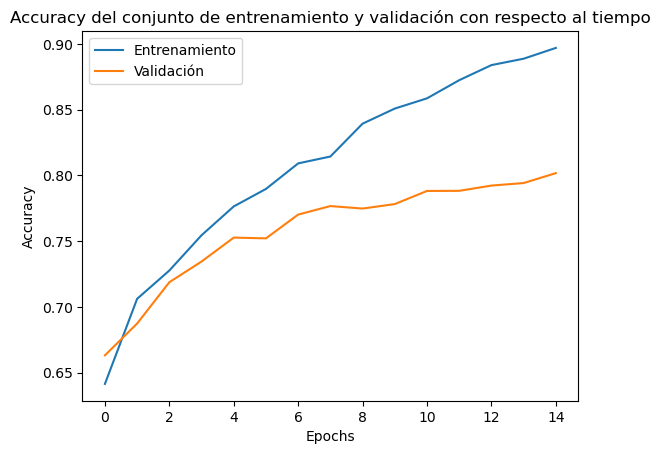

In [25]:
train_acc = list(map(float, train_acc))
valid_acc = list(map(float, valid_acc))

plt.plot(range(CONFIG.get("MODEL").get("EPOCH")), train_acc, label="Entrenamiento")
plt.plot(range(CONFIG.get("MODEL").get("EPOCH")), valid_acc, label="Validación")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy del conjunto de entrenamiento y validación con respecto al tiempo")

plt.legend()

plt.show()

Podemos observar como, con el tiempo, el conjunto de validación va perdiendo poco a poco el incremento de `accuracy`. Un aumento de su conjunto de datos podría mejorar dicho aumento. Importantemente, podemos apreciar como el modelo no sufre de `overfitting`. A continuación, mediante el uso del conjunto de test, se evaluará cuan de buenos son las predicciones.


In [40]:
model.eval()

overall_acc = 0
for image, label in test_dl:
    image, label = [data.to(CONFIG.get("DEVICE")) for data in (image, label)]

    test_output = model(image)
    acc = float((test_output.argmax(dim=1) == label).float().mean())
    overall_acc += acc / len(test_dl)

overall_acc

0.8289621949195862

Finalmente, podemos observar como el modelo ha podido generalizar la idea de `gato` o `perro`, ya que la `accuracy` obtenida es, relativamente, alta. Adicionalmente, podemos representar graficamante, para que el lector pueda apreciar, un conjunto de imagenes con sus respectivas predicciones


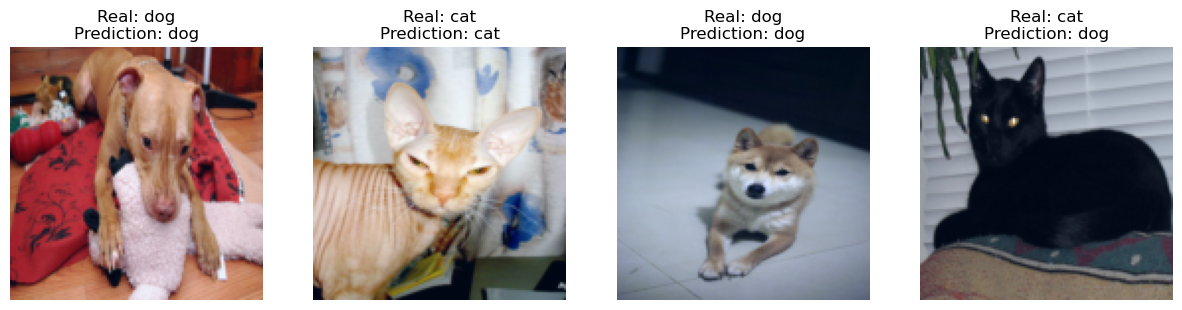

In [104]:
def show_predictions(model, data_loader, n_images=4):
    test_cat_dog_pairs = list(zip(*next(iter(data_loader))))

    random_images = random.sample(test_cat_dog_pairs, n_images)

    fig, axs = plt.subplots(1, n_images, figsize=(15, 10))

    def label_str(label):
        return "dog" if int(label) == 1 else "cat"

    for i, (image, label) in enumerate(random_images):
        prediction = model(torch.unsqueeze(image, 0)).argmax(dim=1)
        image = image.detach().cpu().numpy()

        if image.shape[0] == 1:
            image = np.repeat(image, 3, axis=0)

        image = (image - image.min()) / (image.max() - image.min())

        axs[i].imshow(np.transpose(image, (1, 2, 0)), vmin=0, vmax=1)
        axs[i].set_title(
            f"Real: {label_str(label)}\nPrediction: {label_str(prediction)}"
        )
        axs[i].axis("off")

    plt.show()


show_predictions(model, test_dl)